In [1]:
import numpy as np
import pandas as pd
import os
import glob
import itertools
import scanpy as sc
import natsort
import json

from scroutines import basicu

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_cond_from_biosample(sample):
    """
    """
    cond = sample[:-1]
    if not cond.endswith('DR'): 
        cond = cond+'NR'
        
    return cond

In [3]:
%%time
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/superdupermegaRNA_hasraw_multiome_l23.h5ad'
fout = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/scores_l23abc.csv'

adata_all = sc.read(f)
genes_mul = adata_all.var.index.values
adata_all

CPU times: user 722 ms, sys: 2.34 s, total: 3.06 s
Wall time: 22.2 s


AnnData object with n_obs × n_vars = 38539 × 16572
    obs: 'Age', 'Doublet', 'Doublet Score', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'Class', 'Sample', 'total_counts', 'pct_counts_mt', 'n_genes_by_counts', 'total_counts_mt', 'Doublet?', 'Study', 'Type_leiden', 'cond', 'biosample'
    var: 'feature_types'

In [4]:
unq_samples = natsort.natsorted(adata_all.obs['Sample'].unique())
print(len(unq_samples))
print(unq_samples) 

unq_conds   = natsort.natsorted(adata_all.obs['cond'].unique())
nf = len(unq_conds)
print(nf)
print(unq_conds)

25
['P6a', 'P6b', 'P6c', 'P8a', 'P8b', 'P8c', 'P10a', 'P10b', 'P12DRa', 'P12DRb', 'P12a', 'P12b', 'P12c', 'P14DRa', 'P14DRb', 'P14a', 'P14b', 'P17DRa', 'P17DRb', 'P17a', 'P17b', 'P21DRa', 'P21DRb', 'P21a', 'P21b']
11
['P6NR', 'P8NR', 'P10NR', 'P12DR', 'P12NR', 'P14DR', 'P14NR', 'P17DR', 'P17NR', 'P21DR', 'P21NR']


In [5]:
# 
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot_v3_july8_2024.csv'
anno = pd.read_csv(f)
agenes = anno.loc[anno['P17on']=='A', 'gene'].values
bgenes = anno.loc[anno['P17on']=='B', 'gene'].values
cgenes = anno.loc[anno['P17on']=='C', 'gene'].values
print(agenes.shape, bgenes.shape, cgenes.shape)

agenes = np.intersect1d(agenes, genes_mul)
bgenes = np.intersect1d(bgenes, genes_mul)
cgenes = np.intersect1d(cgenes, genes_mul)
print(agenes.shape, bgenes.shape, cgenes.shape)

(122,) (35,) (129,)
(118,) (34,) (126,)


In [6]:
x = adata_all.raw.X
cov = np.array(x.sum(axis=1)).reshape(-1,)
xln = np.log2(1 + np.array(x.todense()) / cov.reshape(-1,1) * 1e4)
xln

array([[3.9620256, 0.       , 0.       , ..., 0.       , 3.9620256,
        2.5512574],
       [4.525979 , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [3.5832775, 0.       , 0.       , ..., 0.       , 2.6988845,
        0.       ],
       ...,
       [1.6369841, 0.       , 0.       , ..., 0.       , 3.5299144,
        0.       ],
       [3.5615604, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [2.6432807, 0.       , 0.       , ..., 2.169392 , 0.       ,
        0.       ]], dtype=float32)

In [7]:
adata_all.obsm['xln'] = xln

In [8]:
agenes_idx = basicu.get_index_from_array(genes_mul, agenes)
bgenes_idx = basicu.get_index_from_array(genes_mul, bgenes)
cgenes_idx = basicu.get_index_from_array(genes_mul, cgenes)

assert np.all(agenes_idx != -1)
assert np.all(bgenes_idx != -1)
assert np.all(cgenes_idx != -1)

P6NR


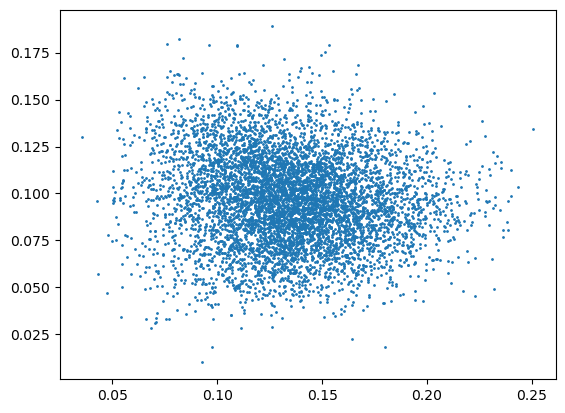

P8NR


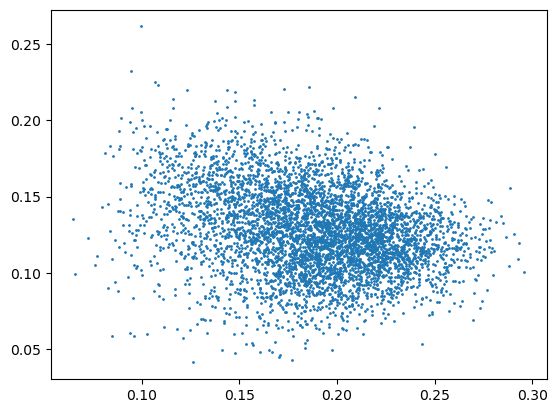

P10NR


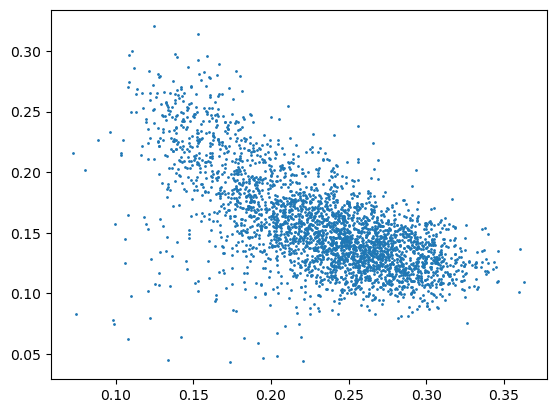

P12DR


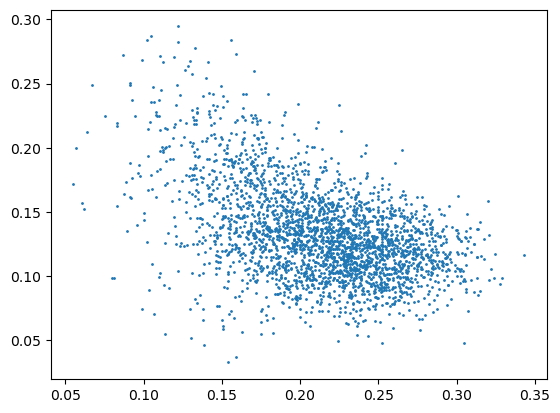

P12NR


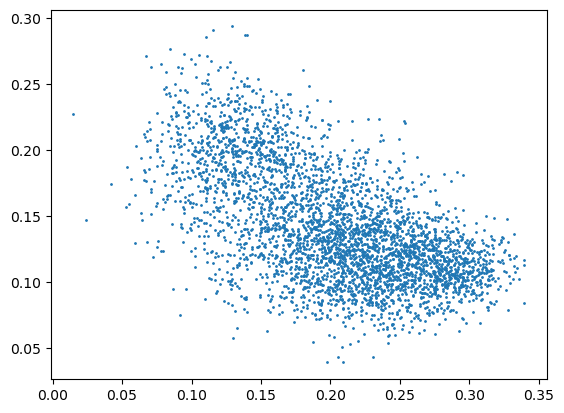

P14DR


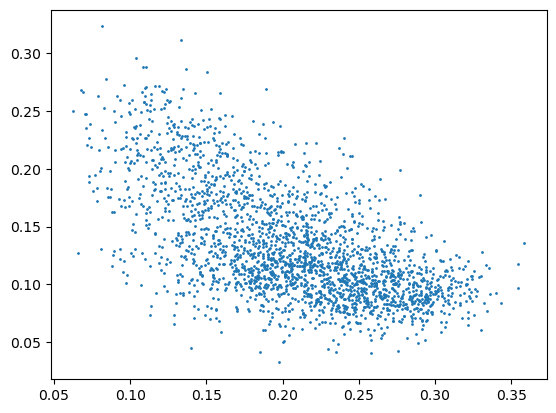

P14NR


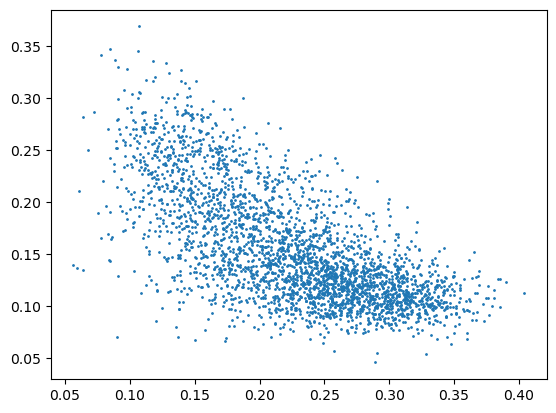

P17DR


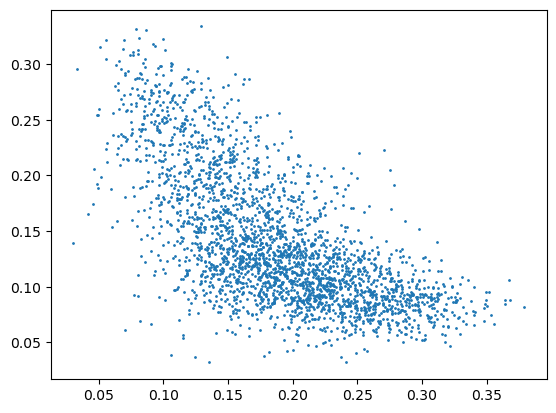

P17NR


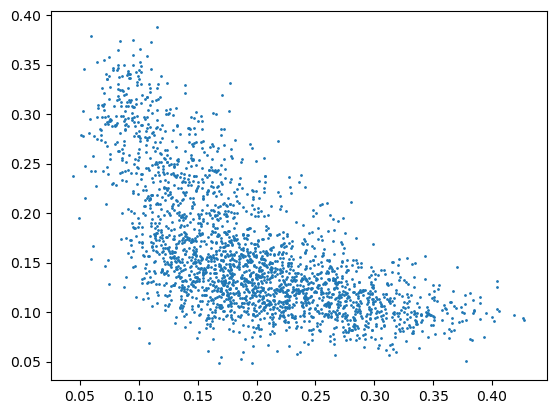

P21DR


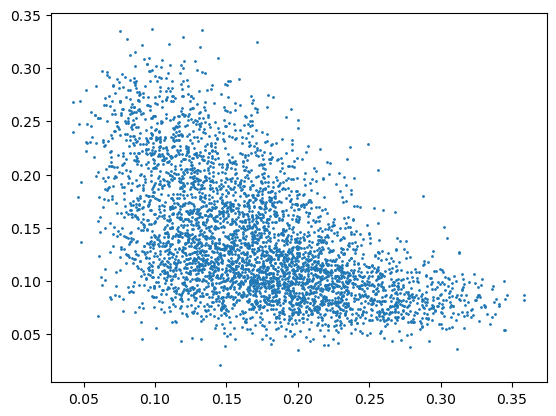

P21NR


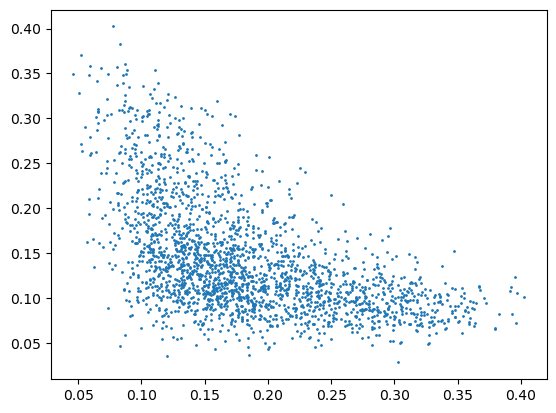

In [9]:
# min max for each gene for each condition 
res_all = []

for i, cond_name in enumerate(unq_conds):
    print(cond_name)
    adata = adata_all[adata_all.obs['cond']==cond_name]
    
    mat = adata.obsm['xln']

    mins = np.min(mat, axis=0)
    maxs = np.max(mat, axis=0)
    nmat = (mat - mins)/(maxs-mins+1e-10)

    scores_a = np.mean(nmat[:,agenes_idx], axis=1)
    scores_b = np.mean(nmat[:,bgenes_idx], axis=1)
    scores_c = np.mean(nmat[:,cgenes_idx], axis=1)
    
    res = pd.DataFrame(index=adata.obs.index.values)
    res['cond'] = cond_name
    res['scores_a'] = scores_a
    res['scores_b'] = scores_b
    res['scores_c'] = scores_c
    res_all.append(res)
    
    plt.scatter(scores_a, scores_c, s=1)
    plt.show()

In [11]:
print(fout)

/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/scores_l23abc.csv


In [10]:
res_df = pd.concat(res_all)
res_df.to_csv(fout, header=True, index=True)